# Project 3: Identifying Depression in r/domesticviolence Subreddit Posts
<img src="./images/domestic_violence.jpg" alt="domestic violence pic"/>

- [Webscraping and Data Collection](./1_Webscraping_and_Data_Collection.ipynb)
- [Preprocessing and EDA](./2_Preprocessing_and_EDA.ipynb)
- <b>Modeling - Multinomial Naive Bayes</b>
- [Modeling - Logistic Regression](./4_Modeling_Logistic_Regression.ipynb)
- [Modeling - Random Forest](./5_Modeling_Random_Forest.ipynb)
- [Production Model and Insights](./6_Production_Model_and_Insights.ipynb)

---
## Overview

Based on the features in the cleaned dataframe, I will now fit each feature, vectorized by Count Vectorization or TF-IDF Vectorization to a Multinomial Naive Bayes model. I will then take the best performing model and optimise its hyperparameters and fit the model again. From there, I will be able to glean insights about the coefficient of each word in the model and how much it affects the prediction of the target vector (```is_depression```). The best model will be taken into consideration for the final production model. 

---
## Contents
- [Importing libraries and data](#Importing-libraries-and-data)
- [Baseline accuracy score ](#Baseline-accuracy-score )
- [Multinomial Naive Bayes model](#Multinomial-NB-model)
- [Optimising parameters](#Optimising-parameters-for-Multinomial-NB-model)
- [Insights](#Insights-from-Multinomial-NB-model)
- [Conclusion](#Conclusion)

---
## Importing libraries and data

In [35]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

In [36]:
#import cleaned dataframe
model_df = pd.read_csv('./data/dv_depression_cleaned_for_model.csv')
model_df.head()

,is_depression,post,title,post_word_count
0,1,think anxiety depression triggered pandemic living abroad europe hit go back home united states 3 months back europe mental health even worse crave home feeling trapped europe escape getting panic attacks first time 5 years mom oded addicted prescription drugs struggling grieving complicated relationship want right mom cares alive could hug tell everything okay instead go searching comfort partners current one grown distant ever since long distance feel even lonelier misunderstood right single see first time tomorrow months bail stress different country poor dad lives alone back states eating away feel guilty also feeling scared fall extreme anxiety depression like mom plans live abroad good life ruined afraid handle living abroad afraid handle life general afraid amount nothing feel like one talk friends europe close friends want burden friends back home vent even feeling severely depressed 2 months ago know turn,felt depressed since mom passed,927
1,1,mentioned feeling online friend suggested maybe suffering depression know whether able get examination help kind feel like deserve alive felt never felt bad thanks reading,received diagnosis feel alone,171
2,0,abusive childhood say term loosely 11 16yo memory progressively gotten worse previously diagnosed ptsd never completed therapy expensive started losing memories childhood even remember recently e eat today regularly scheduled times daily activities done done week certain memories seem clear head told conversations occurrences never happened often dream vividly recall dreams great detail mix things actually happened always intellectually inclined excelled school increasingly found struggling common words remembering basic academic concepts would come naturally relationships studies taken major nosedives stressful able explain remember anything family used joke memory elephant lucky remember today please help whether advice knowing someone understands going,help memory loss,765
3,0,long story short 5 6 years ago may 24th w momma family birthday eating shopping night comes dad gets home intoxicated drugs bro sis upstairs stairs w momma dad momma arguing started beating mma shit ground pounding face thought going kill get headlock squeeze hard almost bit chunk arm grew lot hate towards really get passed event ruined person turned violent person talk keep double thinking know ask feel like need conversation idk kinda lost confused moment,traumatized,461
4,0,http pegrowe com page _id 1595 http pegrowe com page_id 1595 hope seen self promotion wrote essay class jr college actually long time ago wrote educational benefit kind therapy left abusive marriage ways looking back learning looking present wondering looking future hope would rerun shared originally still simply experience details share interested another woman going situations explanation children mom might go leaves horrible situation perpetrator maybe see another point view stop probably dream come really unhealthy dysfunctional family continued mess married first time made day trying clean mess fact probably rest life trying good news things get better light end tunnel still share reasons hope helps someone really good academic work something simple understood might open door someone today student osu oregon state 57 yrs old 2nd marriage kids grown house ways things keep getting better least terms abuser recovery childhood adulthood today complex ptsd anxiety stuff depression etc fight continues encourage anyone everyone horrible situations come swinging metaphorical way care first care world ever able care kids abusive one getting safe free terrorized healthy taking power back giving voice experiences till get move move enjoy life quit living fear,NaN,1273


In [37]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1958 entries, 0 to 1957
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   is_depression    1958 non-null   int64 
 1   post             1956 non-null   object
 2   title            1937 non-null   object
 3   post_word_count  1958 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 61.3+ KB


In [38]:
#null values appeared after importing cleaned dataframe
model_df.isnull().sum()

is_depression       0
post                2
title              21
post_word_count     0
dtype: int64

In [39]:
#the null values appear to be empty strings in 'post' and 'title'
#which did not surface as null values in the previous notebook
model_df[model_df.isna().any(axis=1)]

,is_depression,post,title,post_word_count
4,0,http pegrowe com page _id 1595 http pegrowe com page_id 1595 hope seen self promotion wrote essay class jr college actually long time ago wrote educational benefit kind therapy left abusive marriage ways looking back learning looking present wondering looking future hope would rerun shared originally still simply experience details share interested another woman going situations explanation children mom might go leaves horrible situation perpetrator maybe see another point view stop probably dream come really unhealthy dysfunctional family continued mess married first time made day trying clean mess fact probably rest life trying good news things get better light end tunnel still share reasons hope helps someone really good academic work something simple understood might open door someone today student osu oregon state 57 yrs old 2nd marriage kids grown house ways things keep getting better least terms abuser recovery childhood adulthood today complex ptsd anxiety stuff depression etc fight continues encourage anyone everyone horrible situations come swinging metaphorical way care first care world ever able care kids abusive one getting safe free terrorized healthy taking power back giving voice experiences till get move move enjoy life quit living fear,NaN,1273
49,0,need leave decided leave looking housing lead apartment leave hard act like everything normal planning go behind scenes hurts bad leave hurts stay,NaN,146
92,0,week today get plane cats dog never see abuser wanted share proud,NaN,65
121,0,hey guys 3 brothers parents together overall preety good life parents treat right brothers treat right except one suffering long time suffer lot inside know preety much steals everything got new clothes use new headphones use steal whenever wants lot examples example got new pc 2 years ago go like 7 months like rugby player big guy tiny goalkeeper confront told parents think right say anything keeps going idk said inside family nothing happens nothing ever happen time like treat different like common family problems get yelled nothing,NaN,540
147,1,hi sorry publicize negative thoughts today hard one go thought really mentally strong would never feel guess broken defeated matter bad parents calls names get hit even get locked think temporary smile back face however year different year suicidal thoughts nightmares anger hatred negatives thoughts wont stop surrounding dont know amd talk scared talking make come true scared everything go waste pain suffering endure close ending everything come rushing ready give stop ever stop thinking way,NaN,496
200,1,next month gonna 14 always kinda depressed talk anyone 8 something like parents started argue lot one point got physical dad went jail 10 months got divorced dad still big problem us thought sick like mentally things put mom brother sister terrible remember got drunk locked brothers room waited dad calm also remember many times would grab knife front us say gonna slit throat 2 weeks ago 2 year anniversary death better moved place 2 miles away even 2 years dads death told anyone sleep 3 hours everyday listen music love games good financially play games ease mind trauma everything happened really hard first time talking someone everyone dealing deppresion keep pushing get better least everyone says helps guys get day help would great,NaN,741
246,0,NaN,long post know mother possibly emotionally financially abusive boyfriend,0
292,1,things used gaming listening music daydreaming etc feel anymore like lost magic anybody else know feeling,NaN,105
607,0,hi posting throwaway account want anonymous apologies long post advance need outside perspective advice 23f partner 31m together since 17 living ex first started seeing assured broken year found still together told make choice chose moved flat shared ex left everything owned together moved father took gap year going uni problems started started blame losing everything life became depressed suicida

In [40]:
model_df['post'].fillna('nopost', inplace=True)
model_df['title'].fillna('notitle', inplace=True)
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1958 entries, 0 to 1957
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   is_depression    1958 non-null   int64 
 1   post             1958 non-null   object
 2   title            1958 non-null   object
 3   post_word_count  1958 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 61.3+ KB


In [7]:
#create column containing all words from 'title' and 'post'
model_df['all_words'] = model_df['title'] + ' ' + model_df['post']

model_df.head(2)

,is_depression,post,title,post_word_count,all_words
0,0,unless get extremely stoned often come stop th...,get intrusive thoughts memories physical abuse,261,get intrusive thoughts memories physical abuse...
1,1,saw george floyd clip know part cries mama mad...,kids afraid crying,363,kids afraid crying saw george floyd clip know ...


In [8]:
#exporting cleaned dataframe for other modeling notebooks
model_df.to_csv('./data/dv_depression_cleaned_for_model_final.csv', index=False)

---
## Baseline accuracy score

The accuracy score is 0.50 if every data point is predicted to be ```is_depression``` = 0 (majority class). The model should have a higher score. 

In [9]:
model_df['is_depression'].value_counts(normalize=True)

0    0.509704
1    0.490296
Name: is_depression, dtype: float64

---
## Multinomial NB model

I created functions that would run and return the performance of a Count Vectorization with Multinomial NB and TF-IDF Vectorization with Multinomial NB on all feature columns, i.e., ```title```(words in title), ```post```(words in post), ```all_words```(all words in title and post). The dataframes below show the performance of each feature matrix.

The best model was Count Vectorization with Multinomial NB with the ```all_words``` column as the feature matrix

It has the highest accuracy score and least variance between train and test scores. It also has the highest sensitivity,	specificity,	precision,	ROC AUC score and  f1-score

In [10]:
def cvec_nb_model(list_of_col):

    results_list = []
    for col in list_of_col:
    
    #features matrix(X) and target vector(y)
        X = model_df[col]
        y = model_df['is_depression']

        #train-test-split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, 
                                                            stratify=y, 
                                                            random_state = 42)

        #instantiate cvec
        cvec = CountVectorizer()

        #fit and transform
        X_train = cvec.fit_transform(X_train).todense()
        X_test = cvec.transform(X_test).todense()

        #instantiate multinomial nb
        nb = MultinomialNB()

        #fit nb 
        nb.fit(X_train, y_train)

        #preds from nb model 
        pred = nb.predict(X_test)

        #generate confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

        #calculate roc auc score 
        pred_proba = [i[1] for i in nb.predict_proba(X_test)]
        roc = roc_auc_score(y_test, pred_proba)

        #create table of results using dictionary
        results = {}
        results['features matrix (X)'] = col
        results['model'] = 'cvec + multinomial nb'
        results['train accuracy score'] = nb.score(X_train, y_train)
        results['test accuracy score'] = nb.score(X_test, y_test)
        results['confusion matrix'] = {'tn':tn, 'fp': fp, 'fn': fn, 'tp': tp}
        results['sensitivity'] = tp/(tp+fn)
        results['specificity'] = tn/(tn+fp)
        results['precision'] = tp/(tp+fp)
        results['roc auc score'] = roc
        results['train f1-score'] = f1_score((nb.predict(X_train)), y_train)
        results['test f1-score'] = f1_score(pred, y_test)

        results 
        
        #append results dict to results_list
        results_list.append(results)
        
    #return dataframe of results for each model
    return(pd.DataFrame(results_list)).round(2)

In [11]:
def tvec_nb_model(list_of_col):

    results_list = []
    for col in list_of_col:
    
        #features matrix(X) and target vector(y)
        X = model_df[col]
        y = model_df['is_depression']

        #train-test-split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, 
                                                            stratify=y, 
                                                            random_state = 42)

        #instantiate tvec
        tvec = TfidfVectorizer()

        #fit and transform
        X_train = tvec.fit_transform(X_train).todense()
        X_test = tvec.transform(X_test).todense()

        #instantiate multinomial nb
        nb = MultinomialNB()

        #fit nb 
        nb.fit(X_train, y_train)

        #preds from nb model 
        pred = nb.predict(X_test)

        #generate confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

        #calculate roc auc score 
        pred_proba = [i[1] for i in nb.predict_proba(X_test)]
        roc = roc_auc_score(y_test, pred_proba)

        #create table of results using dictionary
        results = {}
        results['features matrix (X)'] = col
        results['model'] = 'tvec + multinomial nb'
        results['train accuracy score'] = nb.score(X_train, y_train)
        results['test accuracy score'] = nb.score(X_test, y_test)
        results['confusion matrix'] = {'tn':tn, 'fp': fp, 'fn': fn, 'tp': tp}
        results['sensitivity'] = tp/(tp+fn)
        results['specificity'] = tn/(tn+fp)
        results['precision'] = tp/(tp+fp)
        results['roc auc score'] = roc
        results['train f1-score'] = f1_score((nb.predict(X_train)), y_train)
        results['test f1-score'] = f1_score(pred, y_test)

        results 
        
        #append results dict to results_list
        results_list.append(results)
    
    #return dataframe of results for each model 
    return(pd.DataFrame(results_list)).round(2)

**Count Vectorization involves counting the number of occurrences each words appears in a document**

In [12]:
cvec_nb_model(['title', 'post', 'all_words'])

,features matrix (X),model,train accuracy score,test accuracy score,confusion matrix,sensitivity,specificity,precision,roc auc score,train f1-score,test f1-score
0,title,cvec + multinomial nb,0.91,0.80,"{'tn': 206, 'fp': 44, 'fn': 56, 'tp': 184}",0.77,0.82,0.81,0.89,0.91,0.79
1,post,cvec + multinomial nb,0.97,0.92,"{'tn': 234, 'fp': 16, 'fn': 24, 'tp': 216}",0.90,0.94,0.93,0.97,0.97,0.92
2,all_words,cvec + multinomial nb,0.97,0.94,"{'tn': 240, 'fp': 10, 'fn': 20, 'tp': 220}",0.92,0.96,0.96,0.98,0.97,0.94


**Term Frequency-Inverse Document Frequency (TF-IDF) tells whether a word appears frequently in some posts and less frequently in others**

In [13]:
tvec_nb_model(['title', 'post', 'all_words'])

,features matrix (X),model,train accuracy score,test accuracy score,confusion matrix,sensitivity,specificity,precision,roc auc score,train f1-score,test f1-score
0,title,tvec + multinomial nb,0.93,0.80,"{'tn': 208, 'fp': 42, 'fn': 55, 'tp': 185}",0.77,0.83,0.81,0.89,0.93,0.79
1,post,tvec + multinomial nb,0.94,0.87,"{'tn': 240, 'fp': 10, 'fn': 56, 'tp': 184}",0.77,0.96,0.95,0.97,0.94,0.85
2,all_words,tvec + multinomial nb,0.95,0.89,"{'tn': 246, 'fp': 4, 'fn': 49, 'tp': 191}",0.80,0.98,0.98,0.98,0.95,0.88


#### The best model is Count Vectorization with Multinomial NB with the ```all_words``` column as the feature matrix. 
It has the highest accuracy score and least variance between train and test scores. It also has the highest sensitivity,	specificity,	precision,	ROC AUC score and  f1-score

---
## Optimising parameters for Multinomial NB model

Since we have already found the best combination of features matrix and model, I will now optimise the hyperparameters of the chosen model, before fitting and calculating the performance of the model with these metrics, as seen in the dataframe below:
- Accuracy score
- ROC AUC score
- Sensitivity score
- Specificity score 
- Precision score
- f1-score

I have limited the ```max_features``` to 500 so that the 40 most significant features can be differentiated by their coefficients (in Insight section), while not significantly affecting the scores of the model

In [14]:
#features matrix and target vector
X = model_df['all_words']
y = model_df['is_depression']

#train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, 
                                                    random_state = 42)

#optimising hyperparameters 
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

pipe_params = {
    'cvec__max_features': [100, 200, 500],  
    'cvec__min_df': [1, 5, 10],
    'cvec__max_df': [0.3, 0.5, 0.7],
    'cvec__ngram_range': [(1,1)]
}

gscv = GridSearchCV(pipe, pipe_params, cv=5, n_jobs =-1, verbose=1)
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:   24.8s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [15]:
gscv.best_params_

{'cvec__max_df': 0.7,
 'cvec__max_features': 500,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1)}

In [16]:
#fitting model with optimised params 
best_gscv = gscv.best_estimator_
best_gscv.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('cvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.7,
                                 max_features=500, min_df=1, ngram_range=(1, 1),
                                 preprocessor=None, stop_words=None,
                                 strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('nb',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [17]:
#create dataframe of metrics based on optimised model 
opt_results = pd.DataFrame()

opt_results['features_matrix'] = ['all_words']
opt_results['model'] = ['cvec + multinomial nb']
opt_results['optimised_params'] = [gscv.best_params_]
opt_results['train_score'] = best_gscv.score(X_train, y_train)
opt_results['test_score'] = best_gscv.score(X_test, y_test)

preds = best_gscv.predict(X_test)
tn, fp, fn, tp = cm = confusion_matrix(y_test, preds).ravel()

opt_results['confusion_matrix'] = [f'tn: {tn}, fp: {fp}, fn: {fn}, tp: {tp}']
opt_results['sensitivity'] = tp/(tp+fn)
opt_results['specificity'] = tn/(tn+fp)
opt_results['precision'] = tp/(tp+fp)

pred_proba = [i[1] for i in best_gscv.predict_proba(X_test)]

opt_results['roc_auc_score'] = roc_auc_score(y_test, pred_proba)
opt_results['train_f1'] = f1_score((best_gscv.predict(X_train)), y_train)
opt_results['test_f1'] = f1_score(preds, y_test)

pd.set_option('display.max_colwidth', None)
opt_results.T

,0
features_matrix,all_words
model,cvec + multinomial nb
optimised_params,"{'cvec__max_df': 0.7, 'cvec__max_features': 500, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1)}"
train_score,0.93733
test_score,0.920408
confusion_matrix,"tn: 229, fp: 21, fn: 18, tp: 222"
sensitivity,0.925
specificity,0.916
precision,0.91358
roc_auc_score,0.97195


In [18]:
#export opt_results for use in final model 
opt_results.to_csv('./data/best_multinomial_nb.csv',index=False)

### ROC curve

The ROC curve shows how well the model is at interpreting classes (0 and 1). The more area between the ROC (blue) curve and baseline (yellow line), the better separated the distributions of 0 and 1.

An ROC AUC score of 0.98 means that the distribution is well separated, there is little overlap between false positive and false negatives, therefore minimising wrong predictions 

In [19]:
pred_df = pd.DataFrame({'true_values': y_test,'pred_probs':pred_proba})
pred_df.head()

,true_values,pred_probs
353,0,4.485836e-40
1954,0,1.441273e-13
703,0,3.747522e-11
910,0,1.375224e-05
1525,0,3.775360e-07


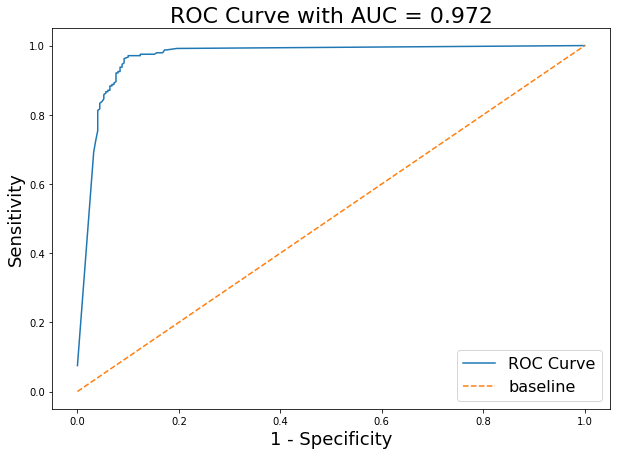

In [20]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    
# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f"ROC Curve with AUC = {round(roc_auc_score(pred_df['true_values'], pred_df['pred_probs']),3)}", fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

---
## Insights from Multinomial NB model

### Words with largest coefficient values 

From the top 500 most significant words (```max_features```), I have plotted a bar graph to show which words affect the prediction of target vector ```is_depression``` the most. The coefficients from the Multinomial NB model are all **negative**. They can be interpreted as follows.

**The top 20 words have the smallest negative coefficient values. They have the LEAST IMPACT in lowering the probability of ```is_depression```.** 
- The bottom 20 words are: ```like, feel, want, know, life, get, even, people, time, really, one, never, would, depression, friends, go, think, day, help, going```
- As word count of ```people``` increases by 1, the probability of target vector ```is_depression``` is **reduced by only 3.68 times**, i.e., higher probability of belonging in r/depression subreddit and lower probability of belonging in r/domesticviolence subreddit

**The bottom 20 words have the largest negative coefficient values. They have the MOST IMPACT in lowering the probability of ```is_depression```.**
- The bottom 20 words are: ```arrested, restraining, report, abuser, court, cops, domestic, verbally, threatened, violence, order, jail, yelling, hitting, kicked, hair, victim, apartment, police, violent```
- As word count of ```arrested``` increases by 1, the probability of target vector ```is_depression``` is **reduced by 10.55 times**, i.e., lower probability of belonging in r/depression subreddit, therefore higher probability of belonging in the r/domesticviolence

In [21]:
#finding coefficients of 500 most siginificant features from model 
coefs = best_gscv.named_steps['nb'].coef_
coefs.shape

(1, 500)

In [22]:
features = best_gscv.named_steps['cvec'].get_feature_names()
len(features)

500

In [23]:
#creating dataframe of words and coefficients 
coef_df = pd.DataFrame({'word':features, 'coef':coefs[0]})
coef_df.head()

,word,coef
0,10,-7.378462
1,20,-7.421021
2,able,-6.102168
3,abuse,-7.783927
4,abused,-8.253931


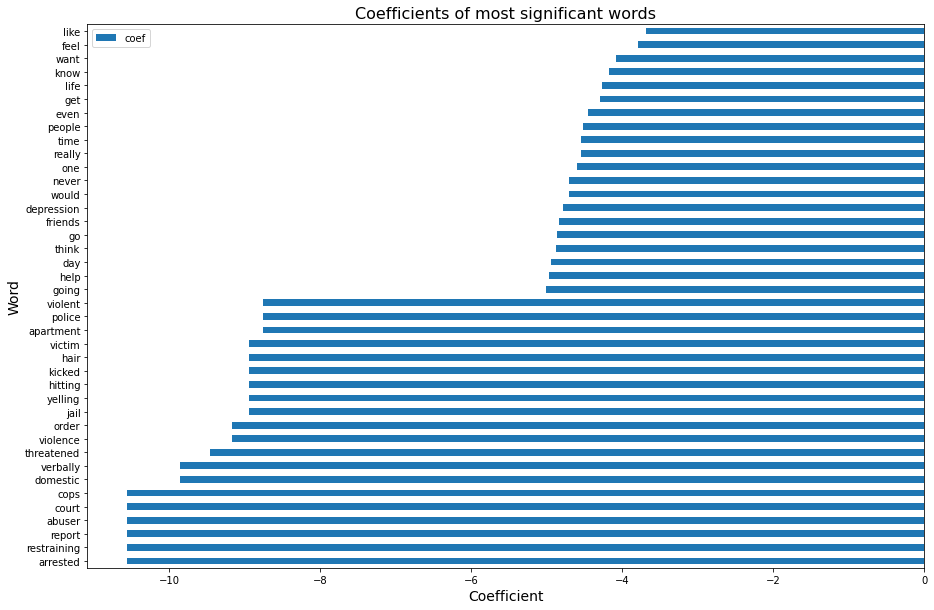

In [30]:
#words with largest negative coefficient values 
bottom_20 = coef_df.sort_values(by = 'coef')[0:20] 

#words with smallest negative coefficient values 
top_20 = coef_df.sort_values(by = 'coef', ascending = False)[0:20]

top_bottom_20 = pd.concat([bottom_20, top_20.sort_values(by = 'coef')], axis =0)

#plot bar chart with 20 words with largest coefficient values and 20 words with smallest coefficient values 
top_bottom_20.plot.barh('word', figsize=(15,10))
plt.title ('Coefficients of most significant words', fontsize=16)
plt.xlabel('Coefficient', fontsize = 14)
plt.ylabel('Word', fontsize = 14);

---
## Conclusion 

The best feature for Multinomial NB was the ```all_words``` column, vectorized with ```CountVectorizer```. It gave a train accuracy score of 0.94 and test accuracy score of 0.92. This indicates that the model will generalise well to unseen data. Its low variance also suggests that the model is not overfit. The ROC AUC score of 0.97 means that there is little overlap between false positive and false negatives, thereby minimising wrong predictions. 

This model will be taken into consideration for the final production model. 

#### Pros and Cons of Multinomial NB
- Pros
    - Works well with text classification 
    - Able to generate coefficients so weightage of each feature can be measured 
- Cons
    - Assumes features are independent and will perform badly if this assumption is not met - which is not the case for this model
    
#### The next notebook will explore Logistic Regression classification modeling